## Main EMR code

In [1]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"
output_directory = project_path * "data/output/case_1/schwarzschild/";

In [3]:
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load

In [2]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load
# gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

  Activating project at `~/Escritorio/TFM/code/01_project`


In [3]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "test_1_cos/"
model_name = "test_1_cos/" #"encoder/" #

output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
predictions_dir = output_dir * "predictions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/"

list_directories = (output_dir, solutions_dir, metrics_dir, img_dir, predictions_dir)
create_directories(list_directories)

In [4]:
# Define neural network model
number_of_hidden_neurons = 64;
activation_function = cos;
NN, NN_params, chain, re = nn_model_case1_arch1(number_of_hidden_neurons, activation_function);

Initializating weights as zero.


In [5]:


# --------------------------------------

datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters

χ₀ = Float64(pi); 
ϕ₀ = Float64(0.0); 
# p_space=Float64.([100,50,70,90]); 
p_space = Float64.([100])
M=Float64(1.0); 
# e_space = Float64.([0.2,0.5,0.8])
e_space = Float64.([0.5])
tspan_train = (0.0f0, 6.0f4)

println("Train dataset creation")
train_info = [];
for e in e_space 
    for p in p_space
        train_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_train, datasize, dt);
        true_info = get_true_solution_EMR_schwarzschild(train_info_i["u0"], train_info_i["model_params"], mass_ratio, M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
        push!(train_info, merge(train_info_i, true_info))
    end
end

# TEST waveform parameters

χ₀ = Float64(pi); 
ϕ₀ = Float64(0.0); 
p=Float64(100.0); 
M=Float64(1.0); 
e_space = Float64.([0.5])
factor = 5
datasize = datasize * factor
tspan_test = (tspan_train[1], tspan_train[2]*factor)

println("Test dataset creation")
test_info = [];
for e in e_space
    test_info_i = get_pinn_EMR_schwarzschild(χ₀, ϕ₀, p, M, e, mass_ratio, tspan_test, datasize, dt);
    true_info = get_true_solution_EMR_schwarzschild(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
    push!(test_info, merge(test_info_i, true_info))
end

# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);


Train dataset creation
Test dataset creation
Processing datasets
Creating test dataset 
Creating train dataset 


Generating zero training steps image


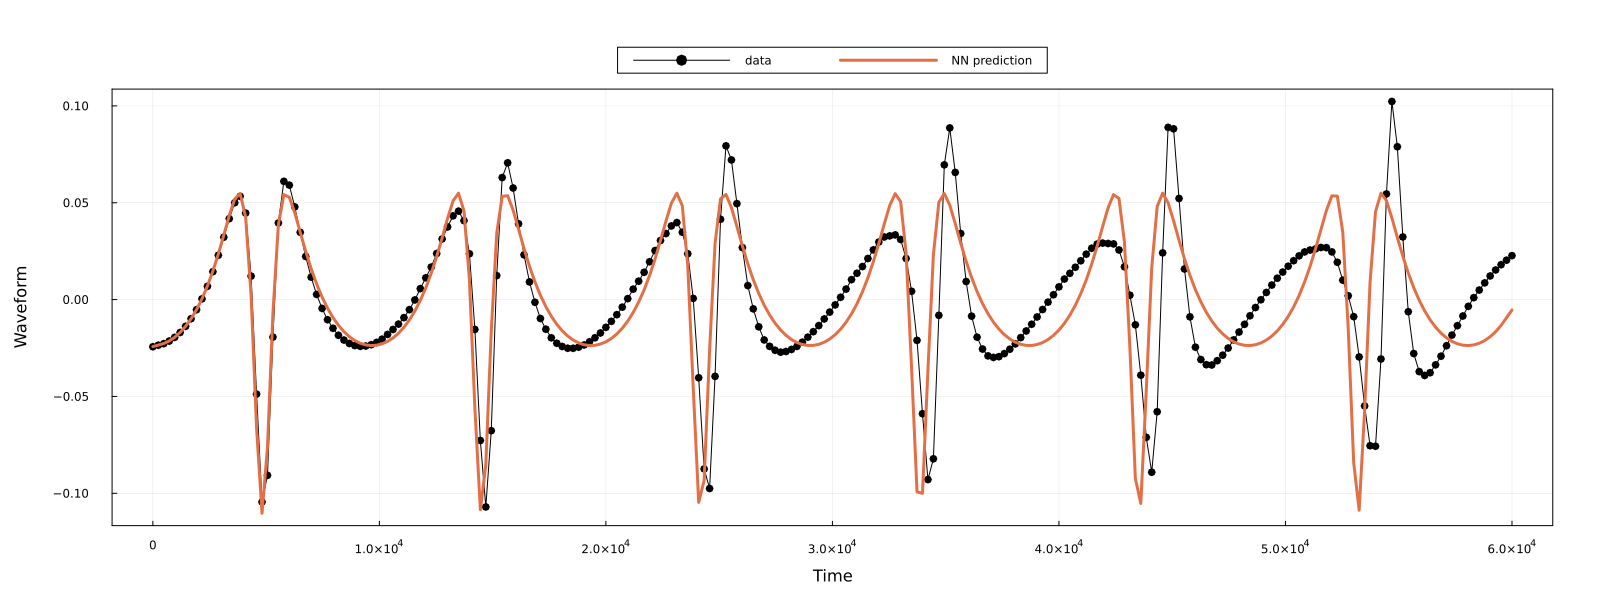

In [6]:
# zero training image

println("Generating zero training steps image")

example = processed_data["train"][1]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform)

In [13]:

train_losses = Vector{Float64}()
test_losses = Vector{Float64}()
train_metrics = Vector{Float64}()
test_metrics = Vector{Float64}()
plot_list = []

callback_EMR(θ::Vector{Float64}, train_loss::Float64, agregated_metrics::Dict{String, Float64}, train_loss_information::Dict, test_loss_information::Dict; show_plots::Bool = show_plots, save_plots_gif::Bool=save_plots_gif) = begin

    # add losses
    push!(train_losses, agregated_metrics["train_loss"])
    push!(test_losses, agregated_metrics["test_loss"])
    push!(train_metrics, agregated_metrics["train_metric"])
    push!(test_metrics, agregated_metrics["test_metric"])

    # train waveform
    title = create_waveform_title(train_loss_information["model_params"][1], train_loss_information["model_params"][2], train_loss_information["model_params"][3], train_loss_information["model_params"][4])
    plt1 = train_plot(train_loss_information["tsteps"], train_loss_information["true_waveform"], train_loss_information["pred_waveform"], title=title)

    # test waveform
    title = create_waveform_title(test_loss_information["model_params"][1], test_loss_information["model_params"][2], test_loss_information["model_params"][3], test_loss_information["model_params"][4])
    plt2 = test_plot(train_loss_information["tsteps"], test_loss_information["tsteps"], test_loss_information["true_waveform"], test_loss_information["pred_waveform"], title=title)

    l = @layout [a; b]
    plt = plot(plt1, plt2, layout=l)
    if save_plots_gif
        push!(plot_list, plt2)
    end

    return false
end


# --------------------------------------

# Train
loss_f(p) = loss_function_case1(p, processed_data=processed_data, batch_size=2)

# optimisers 
# Flux.Optimise.Descent(0.001)
# Flux.Optimise.ADAM(5e-5, (0.9, 0.999)), 
# BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()),

adtype = Optimization.AutoZygote()
optfunct = Optimization.OptimizationFunction((x, p) -> loss_f(x), adtype)
optprob = Optimization.OptimizationProblem(optfunct, NN_params)

res = Optimization.solve(
    optprob,
    BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()),
    callback=callback_EMR,
    maxiters=15
);


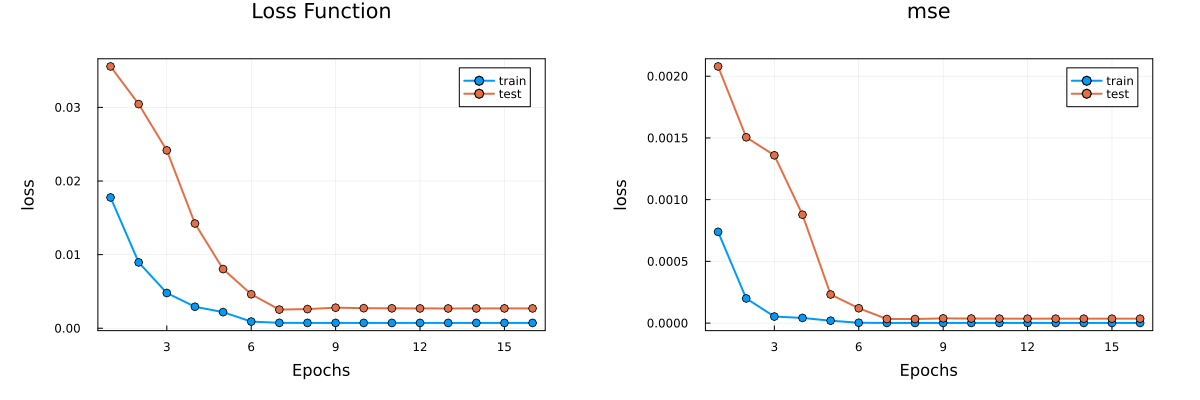

In [14]:
# print("min test loss ", minimum(test_losses), "\n ")
# print("min train loss ", minimum(train_losses))

plot_losses = plot(train_losses, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="Loss Function")
plot!(plot_losses, test_losses, label="test", marker=:o, linewidth=2)

plot_mse = plot(train_metrics, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="mse")
plot!(plot_mse, test_metrics, label="test", marker=:o, linewidth=2)

plot_metrics = plot(plot_losses, plot_mse, layout=(1,2), size=(1200,400), margin=10Plots.mm)

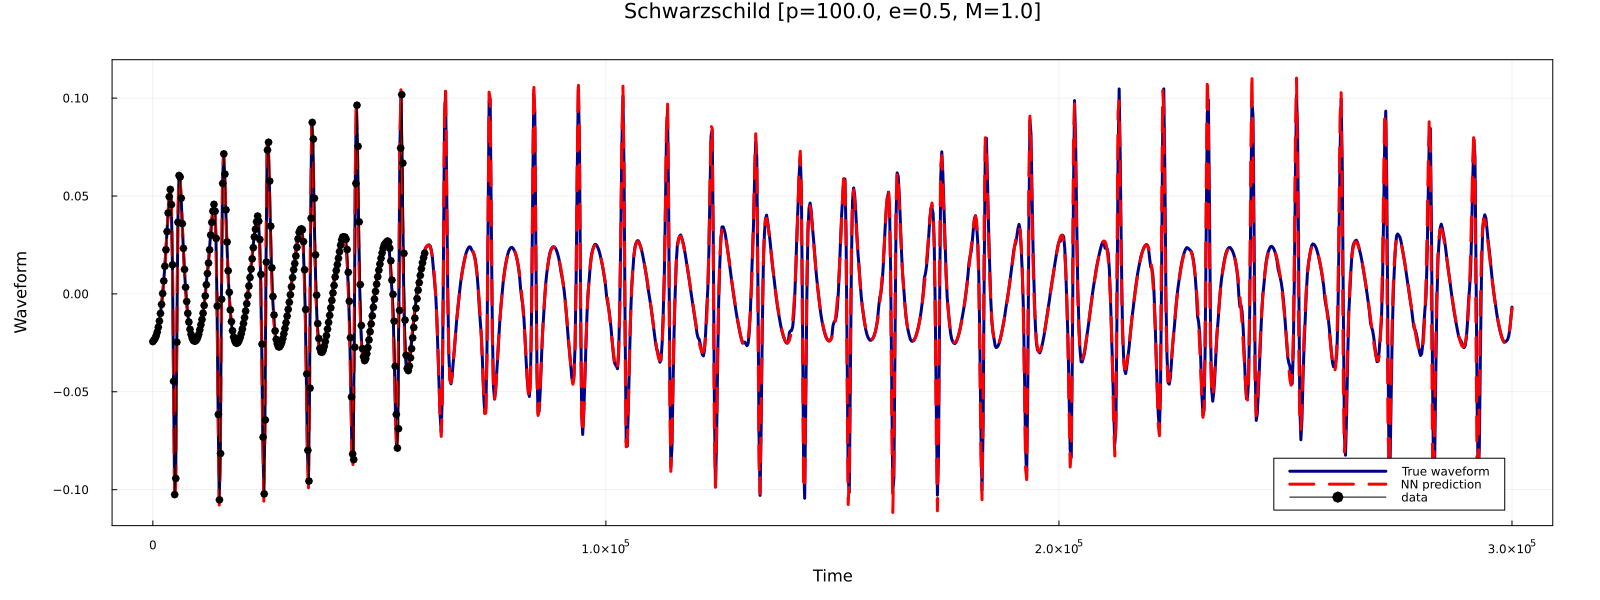

In [18]:
prediction_plot = plot(plot_list[7], title="Schwarzschild [p=100.0, e=0.5, M=1.0]")

In [19]:
savefig(prediction_plot, "./prediction_plot.png")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/src/processing/experiments/schwarzschild/case_1/prediction_plot.png"

In [248]:
# save flux chain models as bson files. To do so, we must save chain model with its parameters
Flux.loadparams!(chain, Flux.params(re(res.minimizer)))
@save solutions_dir*"model_chiphi.bson" chain

losses_file_name = "losses_test.csv"

# save losses
epochs = range(1, length(train_losses))

losses_df = DataFrame(
    epochs = epochs,
    test_name=test_name,
    number_of_hidden_neurons=number_of_hidden_neurons,
    activation_function=string(activation_function),
    train_loss = train_losses,
    test_loss = test_losses,
    train_metric = train_metrics,
    test_metric = test_metrics,
)

if ! isfile(metrics_dir*losses_file_name)
    CSV.write(metrics_dir*losses_file_name, losses_df)
else
    x = DataFrame(CSV.File(metrics_dir*losses_file_name, types=Dict("test_name" => String31)))
    append!(x, losses_df)
    CSV.write(metrics_dir*losses_file_name, x)
end;

In [203]:
if save_data
    savefig(zero_training_plt, img_dir*"0_train_img.pdf")
    savefig(zero_training_plt, img_dir*"0_train_img.png")
    println("Save train images")
    # save plots
    for (ind, img) in enumerate(plot_list)
        savefig(img, img_dir*string(ind)*"_train_img.pdf")
        savefig(img, img_dir*string(ind)*"_train_img.png")
        if ind == length(plot_list)
            savefig(img, output_dir*"prediction_plot.pdf")
            savefig(img, output_dir*"prediction_plot.png")
        end
    end
end